# Data visualization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import sys
sys.path.append('../fpgp')
import plotting_tools
import utils
import symb_reg as sr
import matplotlib.pyplot as plt

from deap import tools

import numpy as np
import pickle

## Load data

In [2]:
data_paths = ('../data/tuning_params',)
exp1 = list(map(utils.LoadedLogs, data_paths)), ['coev', 'exact', 'sl']

In [3]:
data = np.load(data_paths[0] + '/dataset.npz')
trn_x, trn_y = data['trn_x'], data['trn_y']
exp, names = exp1

<IPython.core.display.Javascript object>


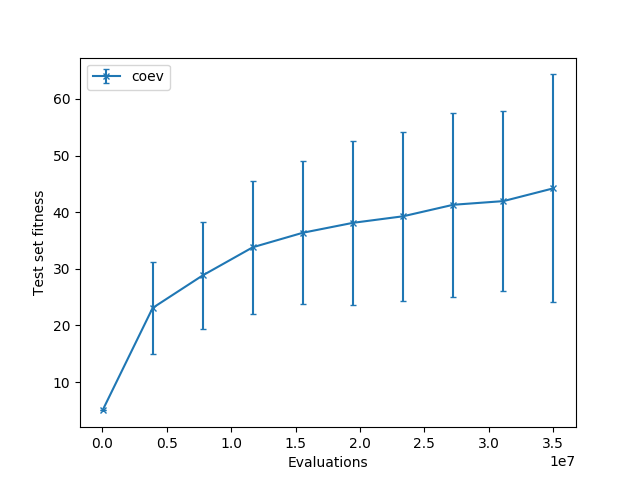

<IPython.core.display.Javascript object>


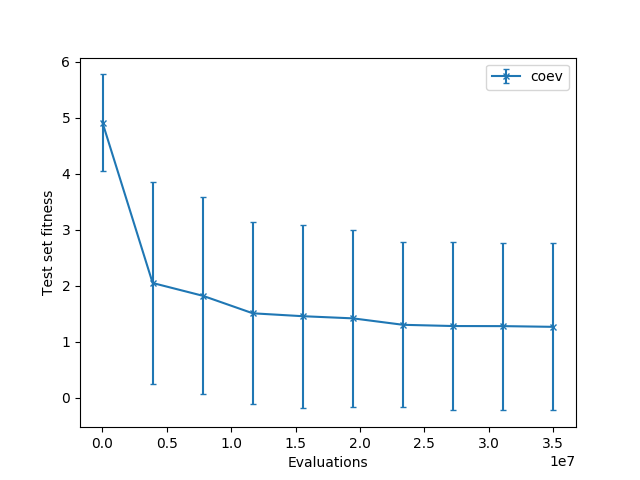

In [4]:
plotting_tools.compare_performance(exp, 'evals', 'pred_size', method_names=names, ignore_tresh=1000, xlabel='Evaluations', ylabel='Test set fitness')
plotting_tools.compare_performance(exp, 'evals', 'test_set_f', method_names=names, ignore_tresh=100, xlabel='Evaluations', ylabel='Test set fitness')
plt.show()

In [ ]:
# select runs
runs = list(list(exp)[0])

In [ ]:
for l in runs:
    plt.plot(l.select('gen'), l.select('pred_size'))
    plt.plot(l.select('gen'), l.select('test_set_f'))
    plt.show()

## Histogram of test set fitnesses

In [ ]:
plt.hist([l[-1]['test_set_f'] for l in runs])
plt.show()

In [ ]:
sorted_logs = sorted(runs, key=lambda x: x[-1]['test_set_f'])
# select run you want to analyze
log = sorted_logs[0] # best run

## Performance of the run

In [ ]:
for l in sorted_logs:
    plotting_tools.show_performance(l, 'evals', 'test_set_f')
    print(l.select('test_set_f')[-1])

## Found solution

In [ ]:
fig, ax = plt.subplots()
ax.plot(trn_x, log[-1]['best_sol_vals'], label='best solution found')
ax.plot(trn_x, trn_y, ls=' ', marker='o', ms='1', label='target function')
ax.legend()
plt.show()

## Histogram of used predictors

In [ ]:
plotting_tools.predictor_histogram(trn_x, trn_y, log)
plt.show()

## Animation of the progress of the run

In [ ]:
anim = plotting_tools.visualize_run(trn_x, trn_y, log, freq=50, step=10)
plt.show()